In [ ]:
import torch
import torch.nn as nn

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
from torchvision.datasets import MNIST, FashionMNIST
from torchvision import transforms

# Define a transform to convert PIL images to PyTorch tensors
transform = transforms.ToTensor()

train_dataset = FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = FashionMNIST(root='./data', train=False, download=True, transform=transform)

100%|██████████| 26.4M/26.4M [00:02<00:00, 12.8MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 203kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.80MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 13.8MB/s]


In [ ]:
from torch.utils.data import DataLoader

train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

In [ ]:
from torch.nn.modules.batchnorm import BatchNorm2d
import torch.nn as nn

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.conv_layers = nn.Sequential(
            # 28x28
            nn.Conv2d(1, 4, kernel_size=3),
            nn.BatchNorm2d(4),
            nn.ReLU(inplace=True),
            # 26x26
            nn.Conv2d(4, 8, kernel_size=3),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            # 24x24
            nn.Conv2d(8, 32, kernel_size=4),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            # 21x21
            nn.Conv2d(32, 64, kernel_size=5),
            nn.BatchNorm2d(64),
            nn.ReLU(True)
            # 17x17
        )

        self.fc = nn.Sequential(
            nn.Linear(17*17*64, 512), # Adjusted input size
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),

            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),

            nn.Linear(256, 1)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        # Начальные полносвязные слои для преобразования шума
        self.fc = nn.Sequential(
            nn.Linear(128, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),

            nn.Linear(512, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(inplace=True),

            nn.Linear(1024, 2048),
            nn.BatchNorm1d(2048),
            nn.ReLU(),
            nn.Linear(2048, 2048),
            nn.BatchNorm1d(2048),
            nn.ReLU(),

            nn.Linear(2048, 7*7*128),  # Подготовка данных для сверток
            nn.BatchNorm1d(7*7*128),
            nn.ReLU(inplace=True)
        )

        # Сверточные слои для генерации изображения
        self.conv_layers = nn.Sequential(
            # Input: 128 channels, 7x7
            nn.ConvTranspose2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            # 256x14x14
            nn.ConvTranspose2d(256, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            # 64x28x28
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),

            # Финальный слой для получения 1 канала
            nn.Conv2d(32, 1, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.fc(x)
        x = x.view(-1, 128, 7, 7)
        x = self.conv_layers(x)

        return x  # Output: (batch_size, 1, 28, 28)

In [ ]:
from torch.optim import Adam
from torch.nn import BCEWithLogitsLoss

G = Generator().to(device)
D = Discriminator().to(device)

loss_func = BCEWithLogitsLoss()

D_optimizer = Adam(D.parameters(), lr = 0.001)
G_optimizer = Adam(G.parameters(), lr = 3e-4)

In [ ]:
from tqdm import tqdm_notebook
EPOCHS = 10

generator_update_ratio = 5 # генератор работает 5 раз, пока дискриминатор 1

for epoch in range(EPOCHS):
    for idx, (img, _) in tqdm_notebook(enumerate(train_loader)):
        idx += 1

        # Train Discriminator
        real_inputs = img.to(device)
        real_outputs = D(real_inputs)
        real_label = torch.ones(real_inputs.shape[0], 1).to(device)

        noise = (torch.rand(real_inputs.shape[0], 128) - 0.5) / 0.5
        noise = noise.to(device)

        fake_inputs = G(noise).detach()
        fake_outputs = D(fake_inputs)
        fake_label = torch.zeros(fake_inputs.shape[0], 1).to(device)

        outputs = torch.cat((real_outputs, fake_outputs), 0)
        targets = torch.cat((real_label, fake_label), 0)

        D_loss = loss_func(outputs, targets)
        D_optimizer.zero_grad()
        D_loss.backward()
        D_optimizer.step()

        # Train Generator multiple times
        for _ in range(generator_update_ratio):
            noise = (torch.rand(real_inputs.shape[0], 128) - 0.5)/0.5
            noise = noise.to(device)

            fake_inputs = G(noise)
            fake_outputs = D(fake_inputs)
            fake_targets = torch.ones([fake_inputs.shape[0], 1]).to(device)

            G_loss = loss_func(fake_outputs, fake_targets)
            G_optimizer.zero_grad()
            G_loss.backward()
            G_optimizer.step()

        if idx % 100 == 0 or idx == len(train_loader):
            print('Epoch {} Iteration {}: discriminator_loss {:.3f} generator_loss {:.3f}'.format(epoch, idx, D_loss.item(), G_loss.item()))
    if (epoch+1) % 10 == 0:
        torch.save(G, 'Generator_epoch_{}.pth'.format(epoch))
        print('Model saved.')

/tmp/ipython-input-523602160.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for idx, (img, _) in tqdm_notebook(enumerate(train_loader)):


0it [00:00, ?it/s]

Epoch 0 Iteration 100: discriminator_loss 0.729 generator_loss 0.749
Epoch 0 Iteration 200: discriminator_loss 0.702 generator_loss 0.708
Epoch 0 Iteration 300: discriminator_loss 0.686 generator_loss 0.712
Epoch 0 Iteration 400: discriminator_loss 0.695 generator_loss 0.698
Epoch 0 Iteration 500: discriminator_loss 0.701 generator_loss 0.707
Epoch 0 Iteration 600: discriminator_loss 0.697 generator_loss 0.730
Epoch 0 Iteration 700: discriminator_loss 0.687 generator_loss 0.706
Epoch 0 Iteration 800: discriminator_loss 0.692 generator_loss 0.699
Epoch 0 Iteration 900: discriminator_loss 0.697 generator_loss 0.699
Epoch 0 Iteration 938: discriminator_loss 0.685 generator_loss 0.716


0it [00:00, ?it/s]

Epoch 1 Iteration 100: discriminator_loss 0.698 generator_loss 0.698
Epoch 1 Iteration 200: discriminator_loss 0.693 generator_loss 0.696
Epoch 1 Iteration 300: discriminator_loss 0.693 generator_loss 0.701
Epoch 1 Iteration 400: discriminator_loss 0.710 generator_loss 0.661
Epoch 1 Iteration 500: discriminator_loss 0.694 generator_loss 0.670
Epoch 1 Iteration 600: discriminator_loss 0.694 generator_loss 0.687
Epoch 1 Iteration 700: discriminator_loss 0.697 generator_loss 0.679
Epoch 1 Iteration 800: discriminator_loss 0.695 generator_loss 0.710
Epoch 1 Iteration 900: discriminator_loss 0.693 generator_loss 0.692
Epoch 1 Iteration 938: discriminator_loss 0.694 generator_loss 0.689


0it [00:00, ?it/s]

Epoch 2 Iteration 100: discriminator_loss 0.696 generator_loss 0.704
Epoch 2 Iteration 200: discriminator_loss 0.691 generator_loss 0.690
Epoch 2 Iteration 300: discriminator_loss 0.699 generator_loss 0.709
Epoch 2 Iteration 400: discriminator_loss 0.691 generator_loss 0.692
Epoch 2 Iteration 500: discriminator_loss 0.699 generator_loss 0.722
Epoch 2 Iteration 600: discriminator_loss 0.687 generator_loss 0.697
Epoch 2 Iteration 700: discriminator_loss 0.693 generator_loss 0.688
Epoch 2 Iteration 800: discriminator_loss 0.695 generator_loss 0.703
Epoch 2 Iteration 900: discriminator_loss 0.684 generator_loss 0.688
Epoch 2 Iteration 938: discriminator_loss 0.705 generator_loss 0.690


0it [00:00, ?it/s]

Epoch 3 Iteration 100: discriminator_loss 0.695 generator_loss 0.713
Epoch 3 Iteration 200: discriminator_loss 0.692 generator_loss 0.711
Epoch 3 Iteration 300: discriminator_loss 0.678 generator_loss 0.713
Epoch 3 Iteration 400: discriminator_loss 0.687 generator_loss 0.704
Epoch 3 Iteration 500: discriminator_loss 0.688 generator_loss 0.689
Epoch 3 Iteration 600: discriminator_loss 0.693 generator_loss 0.700
Epoch 3 Iteration 700: discriminator_loss 0.685 generator_loss 0.713
Epoch 3 Iteration 800: discriminator_loss 0.688 generator_loss 0.714
Epoch 3 Iteration 900: discriminator_loss 0.698 generator_loss 0.700
Epoch 3 Iteration 938: discriminator_loss 0.689 generator_loss 0.724


0it [00:00, ?it/s]

Epoch 4 Iteration 100: discriminator_loss 0.698 generator_loss 0.677
Epoch 4 Iteration 200: discriminator_loss 0.700 generator_loss 0.700
Epoch 4 Iteration 300: discriminator_loss 0.695 generator_loss 0.681
Epoch 4 Iteration 400: discriminator_loss 0.701 generator_loss 0.704
Epoch 4 Iteration 500: discriminator_loss 0.687 generator_loss 0.710
Epoch 4 Iteration 600: discriminator_loss 0.695 generator_loss 0.709
Epoch 4 Iteration 700: discriminator_loss 0.686 generator_loss 0.702
Epoch 4 Iteration 800: discriminator_loss 0.698 generator_loss 0.694
Epoch 4 Iteration 900: discriminator_loss 0.687 generator_loss 0.704
Epoch 4 Iteration 938: discriminator_loss 0.693 generator_loss 0.717


0it [00:00, ?it/s]

Epoch 5 Iteration 100: discriminator_loss 0.692 generator_loss 0.676
Epoch 5 Iteration 200: discriminator_loss 0.688 generator_loss 0.704
Epoch 5 Iteration 300: discriminator_loss 0.687 generator_loss 0.702
Epoch 5 Iteration 400: discriminator_loss 0.678 generator_loss 0.685
Epoch 5 Iteration 500: discriminator_loss 0.693 generator_loss 0.698
Epoch 5 Iteration 600: discriminator_loss 0.685 generator_loss 0.690
Epoch 5 Iteration 700: discriminator_loss 0.696 generator_loss 0.695
Epoch 5 Iteration 800: discriminator_loss 0.681 generator_loss 0.703
Epoch 5 Iteration 900: discriminator_loss 0.699 generator_loss 0.677
Epoch 5 Iteration 938: discriminator_loss 0.692 generator_loss 0.700


0it [00:00, ?it/s]

Epoch 6 Iteration 100: discriminator_loss 0.696 generator_loss 0.696
Epoch 6 Iteration 200: discriminator_loss 0.697 generator_loss 0.694
Epoch 6 Iteration 300: discriminator_loss 0.682 generator_loss 0.713
Epoch 6 Iteration 400: discriminator_loss 0.680 generator_loss 0.711
Epoch 6 Iteration 500: discriminator_loss 0.705 generator_loss 0.713
Epoch 6 Iteration 600: discriminator_loss 0.701 generator_loss 0.692
Epoch 6 Iteration 700: discriminator_loss 0.689 generator_loss 0.712
Epoch 6 Iteration 800: discriminator_loss 0.682 generator_loss 0.735
Epoch 6 Iteration 900: discriminator_loss 0.707 generator_loss 0.701
Epoch 6 Iteration 938: discriminator_loss 0.693 generator_loss 0.720


0it [00:00, ?it/s]

Epoch 7 Iteration 100: discriminator_loss 0.681 generator_loss 0.696
Epoch 7 Iteration 200: discriminator_loss 0.675 generator_loss 0.731
Epoch 7 Iteration 300: discriminator_loss 0.676 generator_loss 0.721
Epoch 7 Iteration 400: discriminator_loss 0.695 generator_loss 0.727
Epoch 7 Iteration 500: discriminator_loss 0.660 generator_loss 0.697
Epoch 7 Iteration 600: discriminator_loss 0.707 generator_loss 0.733
Epoch 7 Iteration 700: discriminator_loss 0.701 generator_loss 0.714
Epoch 7 Iteration 800: discriminator_loss 0.666 generator_loss 0.716
Epoch 7 Iteration 900: discriminator_loss 0.668 generator_loss 0.718
Epoch 7 Iteration 938: discriminator_loss 0.692 generator_loss 0.728


0it [00:00, ?it/s]

Epoch 8 Iteration 100: discriminator_loss 0.731 generator_loss 0.699
Epoch 8 Iteration 200: discriminator_loss 0.694 generator_loss 0.716
Epoch 8 Iteration 300: discriminator_loss 0.713 generator_loss 0.725
Epoch 8 Iteration 400: discriminator_loss 0.703 generator_loss 0.669
Epoch 8 Iteration 500: discriminator_loss 0.704 generator_loss 0.691
Epoch 8 Iteration 600: discriminator_loss 0.688 generator_loss 0.730
Epoch 8 Iteration 700: discriminator_loss 0.679 generator_loss 0.722
Epoch 8 Iteration 800: discriminator_loss 0.709 generator_loss 0.701
Epoch 8 Iteration 900: discriminator_loss 0.699 generator_loss 0.719
Epoch 8 Iteration 938: discriminator_loss 0.714 generator_loss 0.814


0it [00:00, ?it/s]

Epoch 9 Iteration 100: discriminator_loss 0.694 generator_loss 0.707
Epoch 9 Iteration 200: discriminator_loss 0.677 generator_loss 0.723
Epoch 9 Iteration 300: discriminator_loss 0.696 generator_loss 0.731
Epoch 9 Iteration 400: discriminator_loss 0.709 generator_loss 0.703
Epoch 9 Iteration 500: discriminator_loss 0.678 generator_loss 0.768
Epoch 9 Iteration 600: discriminator_loss 0.687 generator_loss 0.712
Epoch 9 Iteration 700: discriminator_loss 0.665 generator_loss 0.742
Epoch 9 Iteration 800: discriminator_loss 0.705 generator_loss 0.698
Epoch 9 Iteration 900: discriminator_loss 0.705 generator_loss 0.750
Epoch 9 Iteration 938: discriminator_loss 0.671 generator_loss 0.794
Model saved.


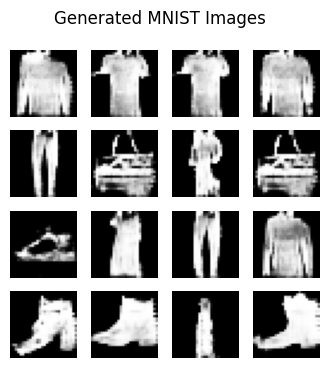

Generator(
  (fc): Sequential(
    (0): Linear(in_features=128, out_features=512, bias=True)
    (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Linear(in_features=512, out_features=1024, bias=True)
    (4): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Linear(in_features=1024, out_features=2048, bias=True)
    (7): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Linear(in_features=2048, out_features=2048, bias=True)
    (10): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
    (12): Linear(in_features=2048, out_features=6272, bias=True)
    (13): BatchNorm1d(6272, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU(inplace=True)
  )
  (conv_layers): Sequential(
    (0): ConvTranspose2d(128, 256, kernel_si

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Set Generator to evaluation mode
G.eval()

# Generate a batch of noise vectors
num_samples = 16 # Number of images to generate
latent_dim = 128 # The latent dimension of your Generator
noise = torch.randn(num_samples, latent_dim).to(device)

# Generate fake images
with torch.no_grad():
    generated_images = G(noise).cpu()

# Plot the generated images
fig = plt.figure(figsize=(4, 4))
for i in range(generated_images.shape[0]):
    plt.subplot(4, 4, i+1)
    # Reshape the image from (1, 28, 28) to (28, 28) for plotting
    plt.imshow(generated_images[i, 0, :, :], cmap='gray')
    plt.axis('off')
plt.suptitle('Generated MNIST Images')
plt.show()

G.train()